In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import SAFutils
import glob

%matplotlib inline
pd.options.display.max_columns = 137

## Aggregate Police Force Across Years

I should get more information to see if the kinds of force are changing

In [3]:
aggregates = {"pf_race":{}, "pf_hour": {}, "pf_day": {}}

for file in glob.glob('2*.csv'):
    year, df = SAFutils.SAF_data_cleaner(file)
    df["used_force"] = np.where((df["pf_hands"] == "Y") | (df["pf_wall"] == "Y") | (df["pf_grnd"] == "Y") |
                            (df["pf_drwep"] == "Y") | (df["pf_ptwep"] == "Y") | (df["pf_baton"] == "Y") | 
                            (df["pf_hcuff"] == "Y") | (df["pf_pepsp"] == "Y") | (df["pf_other"] == "Y"), 1, 0)
    
    aggregates["pf_race"][year] = df.groupby(["race"]).mean()['used_force']
    aggregates["pf_hour"][year] = df.groupby(["hour"]).mean()['used_force'],
    aggregates["pf_day"][year] = df.groupby(["dayofyear"]).mean()['used_force']

## Hourly Trends in Police Force

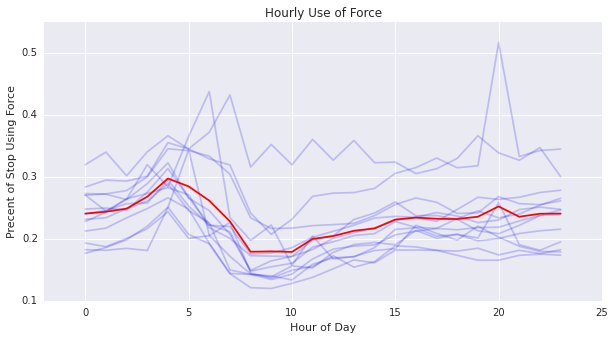

In [4]:
plt.figure(figsize=(10,5))
years = [x for x in range(2003, 2016)]
yr_avgs = np.zeros(24)
for year in years:
    data = aggregates["pf_hour"][year][0]
    yr_avgs = [sum(x) for x in zip(data.values, yr_avgs)]
    plt.plot(data.index, data.values, color='b', alpha=0.2)
    
yr_avgs = [x/len(years) for x in yr_avgs]
plt.plot(yr_avgs, color='r')
plt.xlim([-2,25])
plt.xlabel("Hour of Day")
plt.ylabel("Precent of Stop Using Force")
plt.title("Hourly Use of Force")
plt.show()

### Data Prep for Time Series Plot

In [5]:
import pickle
holder = pickle.load(open("aggregated.p", "rb"))

In [6]:
full_day_series = []
for year, data in sorted(holder["dayofyear"].items()):
    full_day_series += list(data)
    
full_pf_series = []
for year, data in sorted(aggregates["pf_day"].items()):
    full_pf_series += list(data)

In [7]:
# Aggregating at the weekly level

wk_agg_pf = []
for i, val in enumerate(full_pf_series):
    if i % 6 == 0:
        wk_agg_pf.append(val)
    else:
        wk_agg_pf[-1] += val

wk_agg_cnts = []
for i, val in enumerate(full_day_series):
    if i % 6 == 0:
        wk_agg_cnts.append(val)
    else:
        wk_agg_cnts[-1] += val
        
wk_agg_pf = [x/7 for x in wk_agg_pf]
wk_agg_cnts = [x/7 for x in wk_agg_cnts]

## Comparison of Police Force and Number of Incidents 

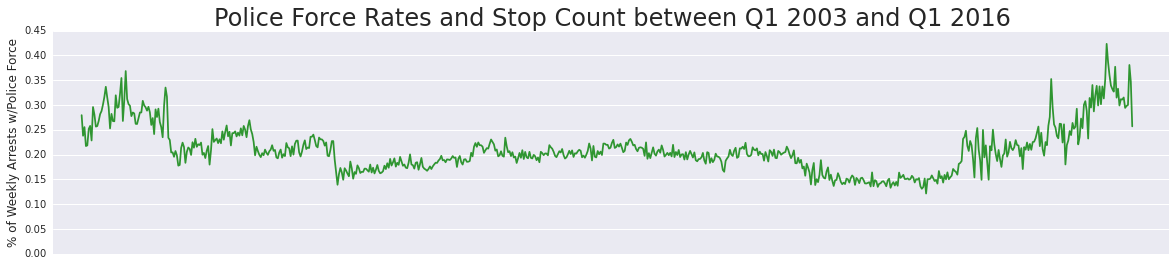

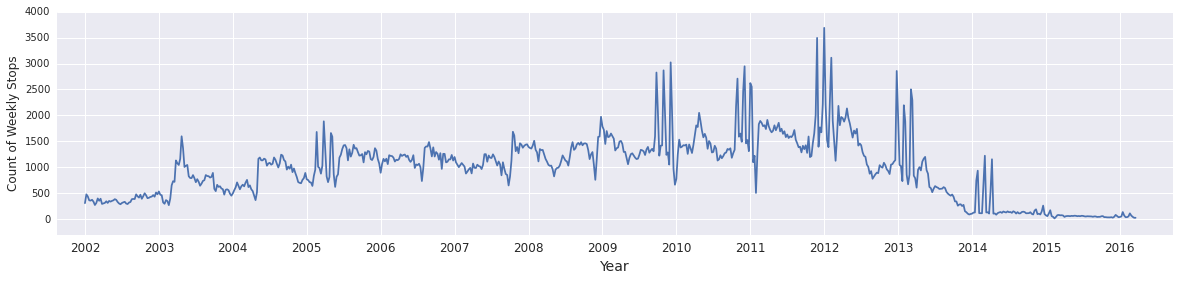

In [48]:
plt.figure(figsize=(20, 4))
plt.plot(wk_agg_pf, color='g', alpha=0.8)
plt.title("Police Force Rates and Stop Count between Q1 2003 and Q1 2016", fontsize=24)
plt.ylabel("% of Weekly Arrests w/Police Force", fontsize=12)
plt.ylim([0, .45])
plt.xlim(-20, 765)
plt.xticks([], [])


plt.figure(figsize=(20,4))
plt.plot(wk_agg_cnts)
plt.ylim([-300, 4000])
plt.xlim(-20, 765)
plt.ylabel("Count of Weekly Stops", fontsize=12)
plt.xticks([x * 52 for x in range(0, 15)], list(range(2002,2017)),fontsize=12)
plt.xlabel("Year", fontsize=14)

plt.show()

In [43]:
cnt_and_pf = zip(wk_agg_pf, wk_agg_cnts)
num_pf = [x * y for x, y in cnt_and_pf]

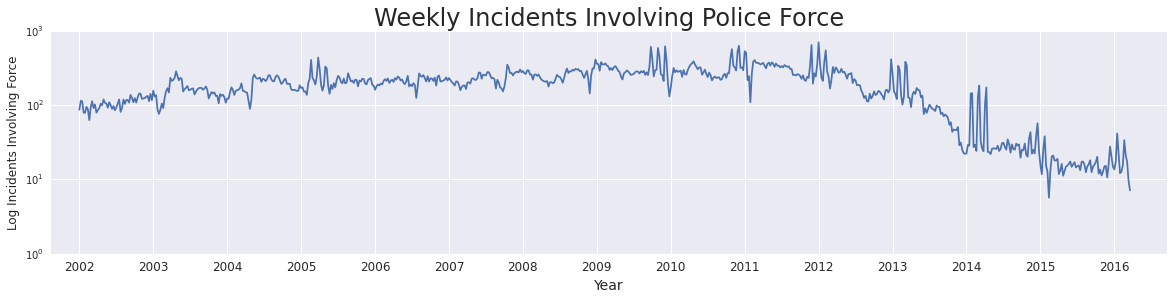

In [52]:
plt.figure(figsize=(20,4))
plt.plot(num_pf)
plt.title("Weekly Incidents Involving Police Force",fontsize=24)
plt.xlim(-20, 765)
plt.semilogy()
plt.ylabel("Log Incidents Involving Force", fontsize=12)
plt.xlabel("Year", fontsize=14)
plt.xticks([x * 52 for x in range(0, 15)], list(range(2002,2017)),fontsize=12)

plt.show()

## Racial Disparities in Police Force

In [24]:
years = [x for x in range(2003, 2016)]
pf_race = {}
for year in years:
    pf_race[year] = aggregates["pf_race"][year]
pf_race_df = pd.DataFrame(pf_race)

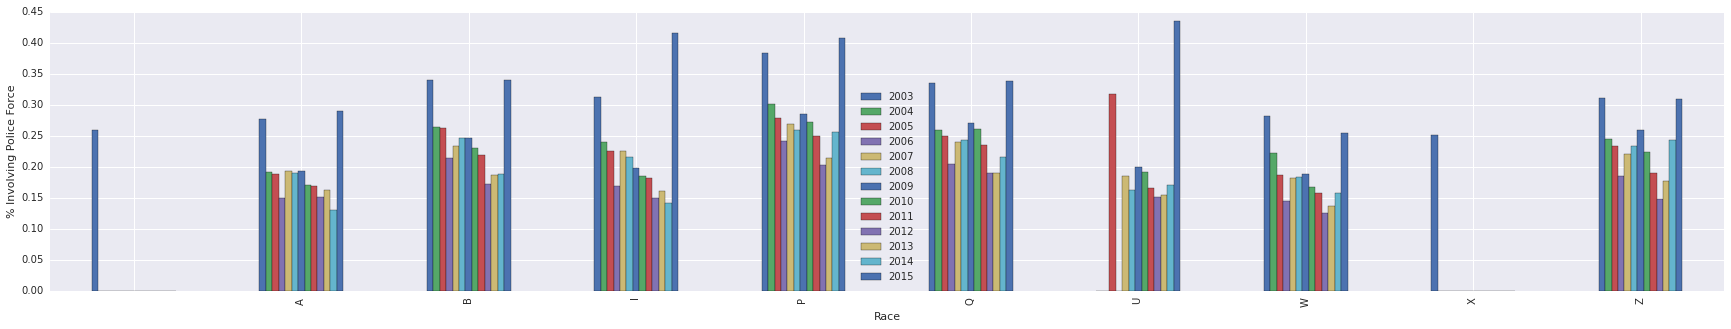

In [25]:
pf_race_df.plot(kind='bar', figsize=(30,5))
plt.ylabel("% Involving Police Force")
plt.xlabel("Race")
plt.show()

### Modeling Likelyhood
Want to develop a model for how different features impact use of force in order to develop a model for interaction

Variables
* Race
* Sex
* Precinct
* Hour of Day
* Year

In [67]:
import statsmodels.api as sm

In [105]:
data = df.loc[:, ["used_force", "sex","race"]]
data = pd.get_dummies(data)
data['intercept'] = 1.0

In [106]:
data.head()

,used_force,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,intercept
0,0,0,1,0,0,0,0,0,0,0,1,0,1
1,1,0,1,0,0,1,0,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,0,0,0,0,1
4,1,0,1,0,0,1,0,0,0,0,0,0,1


In [81]:
import sklearn as skl

In [107]:
small_data = data.sample(frac=.005)
y = small_data.pop("used_force")
small_X = small_data

In [108]:
small_pf_model= sm.Logit(y, small_X).fit()

Optimization terminated successfully.
         Current function value: 0.631731
         Iterations 7


In [104]:
small_X.()

,hour,pct,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,intercept
22064,4,106,0,1,0,0,0,0,0,1,0,0,0,1
19516,23,102,0,1,0,1,0,0,0,0,0,0,0,1
1271,17,41,0,1,0,0,1,0,0,0,0,0,0,1
21855,23,40,0,1,0,0,1,0,0,0,0,0,0,1
19431,19,66,0,1,0,0,0,0,0,1,0,0,0,1


In [109]:
small_pf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             used_force   No. Observations:                 1128
Model:                          Logit   Df Residuals:                     1118
Method:                           MLE   Df Model:                            9
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:                0.005584
Time:                        16:26:57   Log-Likelihood:                -712.59
converged:                       True   LL-Null:                       -716.59
                                        LLR p-value:                    0.5339
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
sex_F         -0.0600        nan        nan        nan           nan       nan
sex_M         -0.0947        nan        nan        nan           nan       nan
sex_Z         -0.4641        nan        nan        nan           nan       nan
race_A        -0.5647        nan        nan        nan           nan       nan
race_B         0.0013        nan        nan        nan           nan       nan
race_I         0.3080        nan        nan        nan           nan       nan
race_P        -0.1210        nan        nan        nan           nan       nan
race_Q         0.2435        nan        nan        nan           nan       nan
race_U         0.0203        nan        nan        nan           nan       nan
race_W        -0.1174        nan        nan        nan           nan       nan
race_Z        -0.3887        nan        nan        nan           nan       nan
intercept     -0.6188        nan        nan        nan           nan       nan
==============================================================================
"""

In [83]:
pf_model= sm.Logit(y, X).fit(maxiter=100000)

         Current function value: 0.635356
         Iterations: 100000


/home/garethjones/.local/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [82]:
pf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             used_force   No. Observations:                22563
Model:                          Logit   Df Residuals:                    22560
Method:                           MLE   Df Model:                            2
Date:                Wed, 31 Aug 2016   Pseudo R-squ.:               7.346e-05
Time:                        13:43:20   Log-Likelihood:                -14336.
converged:                      False   LL-Null:                       -14337.
                                        LLR p-value:                    0.3488
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
sex_F         -0.2164        nan        nan        nan           nan       nan
sex_M         -0.1337        nan        nan        nan           nan       nan
sex_Z         -0.1320        nan        nan        nan           nan       nan
intercept     -0.5611        nan        nan        nan           nan       nan
==============================================================================
"""

In [55]:
df.crimsusp.value_counts()

FEL                               4800
FELONY                            3686
MISD                              3413
CPW                               2399
ROBBERY                           1076
GLA                                732
MISDEMEANOR                        639
BURGLARY                           530
ASSAULT                            343
CPM                                297
PETIT LARCENY                      276
GRAND LARCENY                      271
CRIMINAL TRESPASS                  237
FEL/CPW                            166
CPCS                               133
BURG                               117
CRIM TRES                          117
CT                                 106
ASSAULT 3                           95
CSCS                                94
F                                   93
ASSAULT 2                           88
MIS                                 86
FELONY/ROBBERY                      85
M                                   67
MIS/CPW                  

Should be collecting variance in order to determine error bars?
    Feel like it is probably best practice

In [6]:
df.columns.values

array(['year', 'pct', 'ser_num', 'datestop', 'timestop', 'recstat',
       'inout', 'trhsloc', 'perobs', 'crimsusp', 'perstop', 'typeofid',
       'explnstp', 'othpers', 'arstmade', 'arstoffn', 'sumissue',
       'sumoffen', 'compyear', 'comppct', 'offunif', 'officrid', 'frisked',
       'searched', 'contrabn', 'adtlrept', 'pistol', 'riflshot',
       'asltweap', 'knifcuti', 'machgun', 'othrweap', 'pf_hands',
       'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton',
       'pf_hcuff', 'pf_pepsp', 'pf_other', 'radio', 'ac_rept', 'ac_inves',
       'rf_vcrim', 'rf_othsw', 'ac_proxm', 'rf_attir', 'cs_objcs',
       'cs_descr', 'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth',
       'cs_drgtr', 'ac_evasv', 'ac_assoc', 'cs_furtv', 'rf_rfcmp',
       'ac_cgdir', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 'cs_other',
       'ac_incid', 'ac_time', 'rf_knowl', 'ac_stsnd', 'ac_other',
       'sb_hdobj', 'sb_outln', 'sb_admis', 'sb_other', 'repcmd', 'revcmd',
       'rf_furt', 'rf_bulg', 'offverb'

Investigate 

In [21]:
df["arstmade"] = np.where(df["arstmade"] == "Y", 1, 0)

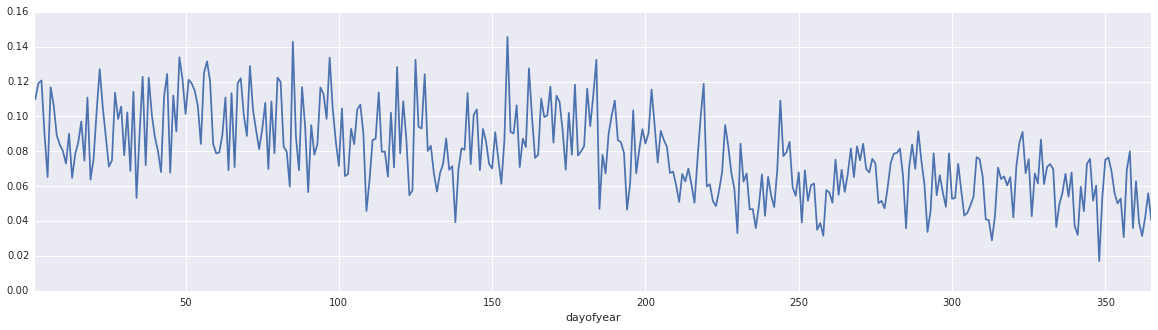

In [33]:
plt.figure(figsize=(20, 5))
df.groupby(["dayofyear"]).mean()["arstmade"].plot()

In [25]:
df.groupby(["race"]).var()["arstmade"]

race
     0.030097
A    0.067672
B    0.070993
I    0.067076
P    0.081295
Q    0.075740
U    0.000000
W    0.077499
X    0.062089
Z    0.053750
Name: arstmade, dtype: float64

In [19]:
df.groupby(["arstmade"]).var()["used_force"]

arstmade
N    0.211756
Y    0.236725
Name: used_force, dtype: float64

In [20]:
df.groupby(["arstmade"]).mean()["used_force"]

arstmade
N    0.304436
Y    0.615298
Name: used_force, dtype: float64

In [2]:
year, df = SAFutils.SAF_data_cleaner("2003.csv")
print(year)

df["used_force"] = np.where((df["pf_hands"] == "Y") | (df["pf_wall"] == "Y") | (df["pf_grnd"] == "Y") |
                        (df["pf_drwep"] == "Y") | (df["pf_ptwep"] == "Y") | (df["pf_baton"] == "Y") | 
                        (df["pf_hcuff"] == "Y") | (df["pf_pepsp"] == "Y") | (df["pf_other"] == "Y"), 1, 0)

2003


In [10]:
df.groupby(["hour"]).mean()["used_force"]

hour
0     0.283506
1     0.294711
2     0.293060
3     0.300885
4     0.355004
5     0.345010
6     0.328962
7     0.319026
8     0.241629
9     0.207151
10    0.231440
11    0.268432
12    0.273679
13    0.274583
14    0.281371
15    0.305565
16    0.314795
17    0.330225
18    0.314637
19    0.317725
20    0.516663
21    0.332755
22    0.342397
23    0.344722
Name: used_force, dtype: float64

In [33]:
hourly_counts = df.groupby(["hour"]).mean()["used_force"]

Probably a good opportunity for a stacked barchart

In [28]:
hours = hourly_counts.index
counts = hourly_counts.values

NameError: name 'hourly_counts' is not defined

In [27]:
plt.plot(hours, counts)
plt.title("Portion of Stops Using Force")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.xlim([0,24])
plt.xticks([0,4,8,12,16,20,24])
plt.show()

NameError: name 'hours' is not defined